In [1]:
import sys
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas/')
sys.path.insert(1,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )
import multiprocessing as mp

import numpy as np
import os
import pandas as pd
import metatlas.metatlas_objects as metob

from matplotlib import pyplot as plt

import glob
# %matplotlib notebook
%matplotlib notebook

from metatlas.helpers import mzmine_helpers as mzm
from metatlas.helpers import pactolus_tools as pt

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',100)


In [3]:
# peak_file = '/project/projectdirs/metatlas/projects/mzmine_parameters/20160824_C18_LIPID___POS_mzmine_output.csv'
# peak_file = '/project/projectdirs/metatlas/projects/mzmine_parameters/Scoelicolor_media_WT_mzmine_output.csv'
# peak_file = '/project/projectdirs/metatlas/projects/mzmine_parameters/Psim_super_C18_pos_mzmine_output.csv'
# peak_file = '/global/homes/b/bpb/Psim_super_C18_pos_mzmine_output_456peaks.csv'
# Psim_pellet_C18_neg
# hedlund_jad2_and_media

# peak_file = '/project/projectdirs/metatlas/projects/mzmine_parameters/Psim_super_C18_neg_mzmine_output.csv'

# pactolus_results = '/scratch2/scratchdirs/bpb/pactolus_runs/hedlund_jad2_and_media/'
# pactolus_results = '/global/cscratch1/sd/bpb/pactolus_runs/rexmalm_pos_super/'
# pactolus_results = '/global/project/projectdirs/metatlas/projects/jgi_projects/Pactolus_Results_20170512_SK_-MR_SupprSoils_EthylAc2/'
pactolus_results = '/project/projectdirs/metatlas/projects/jgi_projects/SolarPanel/Pactolus_Results_20160824_KBL_SolarPanel_MP/'

# ctolus_results = '/project/projectdirs/metatlas/projects/pactolus_runs/20170317_SK_Arkin_PseudoAbxCsource/'


# my_polarity = 'negative'

import glob as glob
trees = glob.glob('/global/cscratch1/sd/bpb/level_3_trees/*.h5')
ref_df = pd.read_pickle('/project/projectdirs/metatlas/projects/magi_paper/unique_compounds.pkl')

In [5]:
output_path = '/global/project/projectdirs/metatlas/projects/jgi_projects/SolarPanel/Pactolus_Results_20160824_KBL_SolarPanel_MP/'
if not os.path.isdir(output_path):
    os.path.mkdir(output_path)
output_pickle = os.path.join(output_path,'pactolus_hits.pkl')
output_csv = os.path.join(output_path,'pactolus_hits.csv')

In [6]:
pactolus_files = [f for f in glob.glob(os.path.join(pactolus_results,'*.h5')) if 'pactolus_results' in os.path.basename(f.lower())]
print len(pactolus_files)
# pactolus_files = [f for f in glob.glob(pactolus_results+'*.h5') if 'pactolus_results_' in f.lower()]

24


In [7]:
# pactolus_results = '/global/cscratch1/sd/bpb/pactolus_runs/Cori_20161209_Manuel_SolarPanel'
max_processes = 64
pt = reload(pt)
pool = mp.Pool(processes=min(max_processes, len(pactolus_files)))
output = pool.map(pt.read_pacolus_results, pactolus_files)
pool.close()
pool.terminate()
for i,f in enumerate(pactolus_files):
    fname = os.path.basename(f).split('.')[0]
    output[i][0]['filename'] = fname
#output has scan_df,tree_df

In [8]:
# important to note that compound==0 is a spectrum with no pactolus hits
msms_df = pd.concat([df[0] for df in output], axis=0)
msms_df.rename(columns={'precursor mz':'precursor_mz','retention time':'retention_time','index':'spectrum_index'},inplace=True)
msms_df['compound'] = msms_df['compound'].fillna(0.0).astype(int)
msms_df['compound_index'] = msms_df['compound']
msms_df.reset_index(inplace=True)
msms_df = msms_df.drop(['index'],1)
msms_df['score'].fillna(0,inplace=True)
msms_df['compound'].fillna(0,inplace=True)
msms_df.head()

,spectrum_index,polarity,precursor intensity,precursor_mz,retention_time,filename,score,compound,compound_index
0,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.030960,126328,126328
1,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.027728,126329,126329
2,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.014015,126196,126196
3,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.001968,126327,126327
4,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.001410,126195,126195


In [8]:
# pactolus_path = '/project/projectdirs/metatlas/projects/pactolus_runs/'
# pactolus_file = 'pactolus_results_20161209_SK_Standards_MSMLS_QE144_50447-638867_MS1_MSMS-POS_MSMLS-PKZ-R9_IR1_148_148.h5'
# import h5py
# min_score=0
# with h5py.File('/project/projectdirs/metatlas/projects/magi_paper/pactolus_results/pactolus_results_20161209_SK_Standards_MSMLS_QE144_50447-638867_MS1_MSMS-POS_MSMLS-PKZ-R9_IR1_148_148.h5','r') as fid:
# #read score_matrix, convert all by all matrix to lists of scores
#     idx = range(fid['score_matrix'].shape[0])  
#     d = {'retention time':fid['scan_metadata']['peak_rt'][idx],
#         'precursor intensity':fid['scan_metadata']['peak_intensity'][idx],
#         'precursor mz':fid['scan_metadata']['peak_mz'][idx],
#         'polarity': fid['scan_metadata']['polarity'][idx],
#         'index': idx}
#     scan_df = pd.DataFrame(d)
#     scan_df['filename'] = pactolus_file

#     m = fid['score_matrix'][:]
#     hits = []
#     for mm in m:
#         idx = np.where(mm>min_score)[0]
#         hits.append(sorted([(mm[i],i) for i in idx])[::-1])
#     df = pd.DataFrame({'scores':hits})
#     b_flat = pd.DataFrame([[i, x[0], x[1]] 
#                        for i, y in df.scores.apply(list).iteritems() 
#                        for x in y], columns=['index','score','compound']).set_index('index')
#     scan_df = scan_df.merge(b_flat, how = 'outer',left_index=True, right_index=True)

#     #get a list of True/False if any hits for a compound:
#     f = np.any(m.T>min_score,axis=1)
#     #only do this for ones that get a hit
#     idx = np.where(f)[0]#range(fid['score_matrix'].shape[1])
# #     lookup = fid['tree_file_lookup_table'][:]
#     d = {'filename': fid['tree_file_lookup_table']['filename'][idx],
#          'ms1_mass': fid['tree_file_lookup_table']['ms1_mass'][idx],
#          'inchi': fid['tree_file_lookup_table']['inchi'][idx],
#          'permanent_charge': fid['tree_file_lookup_table']['permanent_charge'][idx],
#           'index': idx}
# #     get inchikey like this:
#     d['inchi_key'] = [os.path.basename(a).split('.')[0].split('_')[-1] for a in fid['tree_file_lookup_table']['filename'][idx]]

#     tree_df = pd.DataFrame(d)
#     # tree_df.set_index('index',drop=True,inplace=True)
# #     return scan_df,tree_df



In [9]:
compound_df = pd.concat([df[1] for df in output], axis=0)
compound_df.drop_duplicates(inplace=True)
compound_df.set_index('index',drop=True,inplace=True)


In [10]:
cols_to_use = list(set(ref_df.columns.tolist())  - set(compound_df.columns.tolist()))
cols_to_use.append('inchi_key')

compound_df2 = compound_df.reset_index().merge(ref_df[cols_to_use],on='inchi_key',how='inner').reset_index().set_index('index').drop(['level_0'],1)


In [11]:
compound_df2.head()

,filename,inchi,inchi_key,ms1_mass,permanent_charge,mono_isotopic_molecular_weight,creation_time,synonyms,neutralized_2d_inchi_key,chebi_url,img_abc_id,neutralized_2d_inchi,lipidmaps_url,source,kegg_url,hmdb_url,wikipedia_url,formula,number_components,iupac_name,username,pubchem_compound_id,description,metacyc_id,kegg_id,hmdb_id,chebi_id,neutralized_inchi_key,neutralized_inchi,name,num_free_radicals,lipidmaps_id,last_modified,pubchem_url,unique_id
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,/project/projectdirs/metatlas/projects/clean_p...,"InChI=1S/C5H8S/c1-5-3-2-4-6-5/h2,4-5H,3H2,1H3",MFAXBTKOLOJEHX-UHFFFAOYSA-N,100.034671,0,100.034671,2016-06-18 01:10:21,"SCHEMBL257408///2,3-Dihydro-2-methylthiophene/...",MFAXBTKOLOJEHX-UHFFFAOYSA-N,,,"InChI=1S/C5H8S/c1-5-3-2-4-6-5/h2,4-5H,3H2,1H3",,hmdb,,http://www.hmdb.ca/metabolites/HMDB33564,,C5H8S,1,,bpb,22054765,,,,HMDB33564,,MFAXBTKOLOJEHX-UHFFFAOYSA-N,"InChI=1S/C5H8S/c1-5-3-2-4-6-5/h2,4-5H,3H2,1H3",SCHEMBL257408,0,,2016-06-18 01:10:21,http://pubchem.ncbi.nlm.nih.gov/compound/22054765,85bf9492e780402486b9454231707741
10,/project/projectdirs/metatlas/projects/clean_p...,"InChI=1S/C5H8S/c1-5-3-2-4-6-5/h3H,2,4H2,1H3",KBUVXRDFMQNIPD-UHFFFAOYSA-N,100.034671,0,100.034671,2016-06-18 01:07:39,"5-Methyl-2,3-dihydrothiophene///2-Methyl-4,5-d...",KBUVXRDFMQNIPD-UHFFFAOYSA-N,,,"InChI=1S/C5H8S/c1-5-3-2-4-6-5/h3H,2,4H2,1H3",,hmdb,,http://www.hmdb.ca/metabolites/HMDB33565,,C5H8S,1,,bpb,559083,,,,HMDB33565,,KBUVXRDFMQNIPD-UHFFFAOYSA-N,"InChI=1S/C5H8S/c1-5-3-2-4-6-5/h3H,2,4H2,1H3","5-Methyl-2,3-dihydrothiophene",0,,2016-06-18 01:07:39,http://pubchem.ncbi.nlm.nih.gov/compound/559083,a8f9ff0d53374ae591534b4e24ac5ef2
11,/project/projectdirs/metatlas/projects/clean_p...,"InChI=1S/C5H9P/c1-5(2,3)4-6/h1-3H3",PXQNAKPBTIQCTI-UHFFFAOYSA-N,100.044187,0,100.044187,2016-06-18 01:15:07,"1-Phospha-1-butyne, 3,3-dimethyl-///2,2-dimeth...",PXQNAKPBTIQCTI-UHFFFAOYSA-N,,,"InChI=1S/C5H9P/c1-5(2,3)4-6/h1-3H3",,wikidata,,,,C5H9P,1,,bpb,144845,,,,,,PXQNAKPBTIQCTI-UHFFFAOYSA-N,"InChI=1S/C5H9P/c1-5(2,3)4-6/h1-3H3","1-Phospha-1-butyne, 3,3-dimethyl-",0,,2016-06-18 01:15:07,http://pubchem.ncbi.nlm.nih.gov/compound/144845,be64e0f381394d2290b21507c52c3fce
53,/project/projectdirs/metatlas/projects/clean_p...,"InChI=1S/C4H9BO2/c1-4-5(6-2)7-3/h4H,1H2,2-3H3",MHTUGAFHHNZMNV-UHFFFAOYSA-N,100.069560,0,100.069560,2016-06-18 01:10:29,dimethyl ethenylboronate///CHEBI:50984,MHTUGAFHHNZMNV-UHFFFAOYSA-N,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,"InChI=1S/C4H9BO2/c1-4-5(6-2)7-3/h4H,1H2,2-3H3",,chebi,,,,C4H9BO2,1,,bpb,25058192,,,,,CHEBI:50984,MHTUGAFHHNZMNV-UHFFFAOYSA-N,"InChI=1S/C4H9BO2/c1-4-5(6-2)7-3/h4H,1H2,2-3H3",dimethyl ethenylboronate,0,,2016-06-18 01:10:29,http://pubchem.ncbi.nlm.nih.gov/compound/25058192,95d84c12d95248548dbc0b8e600fa2ba
54,/project/projectdirs/metatlas/projects/clean_p...,"InChI=1S/C6H12O/c1-2-3-4-5-6-7/h3-4,7H,2,5-6H2...",UFLHIIWVXFIJGU-ONEGZZNKSA-N,100.088815,0,100.088815,2016-06-18 01:19:37,trans-3-Hexen-1-ol///(E)-Hex-3-en-1-ol///trans...,UFLHIIWVXFIJGU-UHFFFAOYSA-N,,,"InChI=1S/C6H12O/c1-2-3-4-5-6-7/h3-4,7H,2,5-6H2...",http://www.lipidmaps.org/data/LMSDRecord.php?L...,lipidmaps,,,,C6H12O,1,,bpb,5284503,,,,,,UFLHIIWVXFIJGU-ONEGZZNKSA-N,"InChI=1S/C6H12O/c1-2-3-4-5-6-7/h3-4,7H,2,5-6H2...",trans-3-Hexen-1-ol,0,LMFA05000113,2016-06-18 01:19:37,http://pubchem.ncbi.nlm.nih.gov/compound/5284503,934b58afc92447adad38717e7129e6b4


In [12]:

temp = msms_df.merge(compound_df2,how='left',left_on='compound',right_index=True)


In [13]:
temp.inchi_key.fillna('',inplace=True)

In [16]:
# temp.to_pickle('/global/homes/b/bpb/Downloads/pseudo5_pactolus.pkl')

### remove peaks that are outside of mz tolerance

In [14]:
def calculate_ppm(theoretical_mass,measured_mz,adduct_masses):
    """
    given theoretical mass vector, measured mz vector, and adduct mass vector
    return the ppm
    #### TODO: add in the adduct names and with an argmin list the adduct name for pactolus hit ####

    Note: 
    theoretical_mass and measured_mz must be [N,1] where N is the number
    of features.
    adduct_masses must be [1,M] where M is the number of adducts
    typical adduct masses for positive mode are [0, 1.007276]
    typical adduct masses negative mode are [-1.007276]

    """
    measured_mz = np.outer(measured_mz,np.ones(adduct_masses.shape))
    theoretical_mass = np.outer(theoretical_mass,np.ones(adduct_masses.shape))
    mz_neutralizations = np.outer(np.ones(measured_mz.shape[0]),adduct_masses)
    mass_difference = abs(measured_mz - mz_neutralizations - theoretical_mass)
    ppm_difference = np.divide(mass_difference,theoretical_mass)*1e6
    return ppm_difference.min(axis=1)


In [15]:
idx = temp['polarity'] == 1
temp['detected_polarity'] = ''

temp.loc[idx,'detected_polarity'] = 'positive' #this sets things up for metatlas
adduct_masses = np.asarray([1.007276]) #assume [M+] and [M+H] are the adducts

temp.loc[idx,'ppm'] = calculate_ppm(temp[idx]['mono_isotopic_molecular_weight'].values,
                                    temp[idx]['precursor_mz'].values,
                                   adduct_masses)
idx = temp['polarity'] == 0
temp.loc[idx,'detected_polarity'] = 'negative' #this sets things up for metatlas
adduct_masses = np.asarray([-1.007276]) #assume [M-H] are the adducts
temp.loc[idx,'ppm'] = calculate_ppm(temp[idx]['mono_isotopic_molecular_weight'].values,
                                    temp[idx]['precursor_mz'].values,
                                   adduct_masses)


<IPython.core.display.Javascript object>


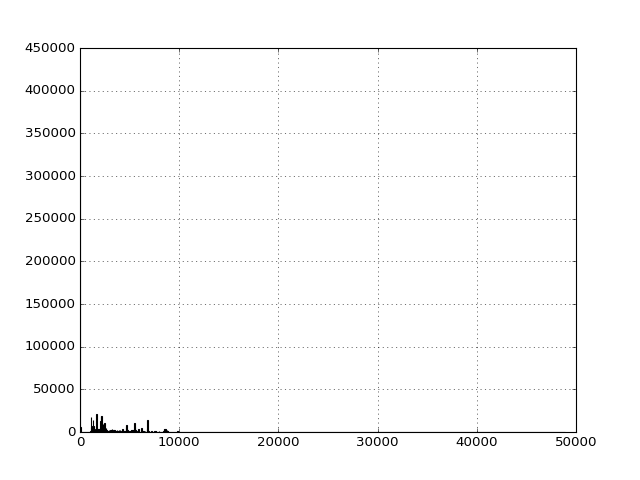

In [16]:
temp.ppm.hist(bins=1000)

<IPython.core.display.Javascript object>


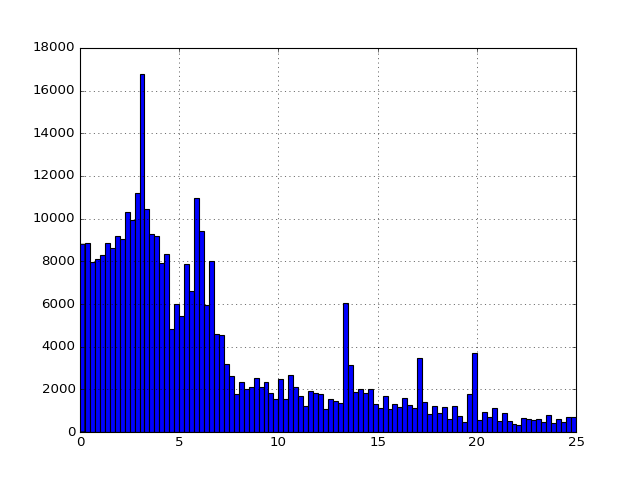

In [27]:
temp_filtered = temp[temp.ppm < 25].copy()
fig = plt.figure()
temp_filtered.ppm.hist(bins=100)
plt.show()

In [18]:
temp.shape

(867589, 46)

In [28]:
temp_filtered.shape

(351140, 46)

In [29]:
temp_filtered.rename(columns={'inchi_key':'original_compound','score':'compound_score'},inplace=True)

In [33]:
len(temp_filtered.original_compound.unique())

32699

In [30]:
temp_filtered.head()

,spectrum_index,polarity,precursor intensity,precursor_mz,retention_time,filename_x,compound_score,compound,compound_index,filename_y,inchi,original_compound,ms1_mass,permanent_charge,mono_isotopic_molecular_weight,creation_time,synonyms,neutralized_2d_inchi_key,chebi_url,img_abc_id,neutralized_2d_inchi,lipidmaps_url,source,kegg_url,hmdb_url,wikipedia_url,formula,number_components,iupac_name,username,pubchem_compound_id,description,metacyc_id,kegg_id,hmdb_id,chebi_id,neutralized_inchi_key,neutralized_inchi,name,num_free_radicals,lipidmaps_id,last_modified,pubchem_url,unique_id,detected_polarity,ppm
0,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.030960,126328,126328,/project/projectdirs/metatlas/projects/clean_p...,InChI=1S/C30H54O12/c1-4-5-6-7-8-9-10-11-12-13-...,LGWRUIALZTVJCL-OODILDFESA-N,606.361527,0.0,606.361527,2016-10-13 19:43:36,,LGWRUIALZTVJCL-UHFFFAOYSA-N,,,InChI=1S/C30H54O12/c1-4-5-6-7-8-9-10-11-12-13-...,,,,,,C30H54O12,0.0,,bpb,,No description,,,,,LGWRUIALZTVJCL-OODILDFESA-N,InChI=1S/C30H54O12/c1-4-5-6-7-8-9-10-11-12-13-...,Untitled,0.0,,2016-10-13 19:48:33,,f531c78607e34f8898765a17e04ae671,positive,14.542177
1,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.027728,126329,126329,/project/projectdirs/metatlas/projects/clean_p...,InChI=1S/C30H54O12/c1-5-6-7-8-9-10-11-12-13-14...,OJANSCBZYLSEIY-ZYSALSKRSA-N,606.361527,0.0,606.361527,2016-10-13 19:44:27,,OJANSCBZYLSEIY-UHFFFAOYSA-N,,,InChI=1S/C30H54O12/c1-5-6-7-8-9-10-11-12-13-14...,,,,,,C30H54O12,0.0,,bpb,,No description,,,,,OJANSCBZYLSEIY-ZYSALSKRSA-N,InChI=1S/C30H54O12/c1-5-6-7-8-9-10-11-12-13-14...,Untitled,0.0,,2016-10-13 19:51:36,,e107e66a306940d886c4b30238f39599,positive,14.542177
3,0,1,1.157535e+09,607.359985,9.141931,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.001968,126327,126327,/project/projectdirs/metatlas/projects/clean_p...,InChI=1S/C37H50O7/c1-23(14-20-32(41)42)13-19-3...,FSKQADSFEYMILN-ROZCPUIOSA-N,606.355654,0.0,606.355654,2016-10-13 19:44:54,,FSKQADSFEYMILN-UHFFFAOYSA-N,,,InChI=1S/C37H50O7/c1-23(14-20-32(41)42)13-19-3...,,,,,,C37H50O7,0.0,,bpb,,No description,,,,,FSKQADSFEYMILN-ROZCPUIOSA-N,InChI=1S/C37H50O7/c1-23(14-20-32(41)42)13-19-3...,Untitled,0.0,,2016-10-13 19:53:14,,aeed79e0c9cf4793bb4a7117b4563391,positive,4.856207
13,1,1,1.157535e+09,608.359985,9.143232,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.000080,126416,126416,/project/projectdirs/metatlas/projects/clean_p...,InChI=1S/C30H49N5O8/c1-8-18(4)24-29(40)34(7)25...,ZYTHYMZQQBWDDS-LSGBTAIHSA-N,607.358114,0.0,607.358114,2016-10-13 19:43:07,,ZYTHYMZQQBWDDS-UHFFFAOYSA-N,,,InChI=1S/C30H49N5O8/c1-8-18(4)24-29(40)34(7)25...,,,,,,C30H49N5O8,0.0,,bpb,,No description,,,,,ZYTHYMZQQBWDDS-LSGBTAIHSA-N,InChI=1S/C30H49N5O8/c1-8-18(4)24-29(40)34(7)25...,Untitled,0.0,,2016-10-13 19:46:18,,a7e4d2c7d9de440f8a73a38f9e07d8d5,positive,8.897842
14,2,1,5.307276e+08,607.563354,9.182587,pactolus_results_20160824_C18_LIPID___POS_MSMS...,0.160458,126370,126370,/project/projectdirs/metatlas/projects/clean_p...,InChI=1S/C39H74O4/c1-3-5-7-9-11-13-15-17-19-21...,QYZMEQIXKKGYKR-CHAYHAMRSA-N,606.558711,0.0,606.558711,2016-06-18 01:16:28,"1-hydroxy-3-[(1Z,9Z)-octadeca-1,9-dien-1-yloxy...",QYZMEQIXKKGYKR-UHFFFAOYSA-N,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,,InChI=1S/C39H74O4/c1-3-5-7-9-11-13-15-17-19-21...,,chebi,,,,C39H74O4,1.0,,bpb,44176405,A 1-O-(alk-1-enyl)-2-O-acylglycerol having a c...,,,,CHEBI:52949,QYZMEQIXKKGYKR-CHAYHAMRSA-N,InChI=1S/C39H74O4/c1-3-5-7-9-11-13-15-17-19-21...,"1-hydroxy-3-[(1Z,9Z)-octadeca-1,9-dien-1-yloxy...",0.0,,2016-06-18 01:16:28,http://pubchem.ncbi.nlm.nih.gov/compound/44176405,ae685dc570e8478bb027e53dabdc677b,positive,4.339820


In [31]:
temp_filtered.to_pickle(output_pickle)

In [32]:
temp_filtered.to_csv(output_csv)

In [ ]:
# pactolus_df.fillna(0,inplace=True)
# peak_df.fillna(0,inplace=True)

# see if compounds are in ema atlas

In [ ]:
ema_df_pos = pd.read_pickle('/project/projectdirs/metatlas/projects/magi_paper/ema_pos_hilic_atlas_50447.pkl')
ema_df_neg = pd.read_pickle('/project/projectdirs/metatlas/projects/magi_paper/ema_neg_hilic_atlas_50447.pkl')
inchikeys = list(set(ema_df_pos.inchi_key.tolist() + ema_df_neg.inchi_key.tolist()))
len(inchikeys)

In [ ]:
pactolus_inchikeys = temp_filtered.inchi_key.tolist()

In [ ]:
len(list(set(inchikeys) - set(pactolus_inchikeys)))

In [ ]:
len(list(set([i.split('-')[0] for i in inchikeys]) - set([i.split('-')[0] for i in pactolus_inchikeys])))

In [ ]:
temp_filtered[(abs(temp_filtered.precursor_mz - 222.097213)<0.001)].sort_values('score',ascending=False)

In [ ]:
selected = temp_filtered[(temp_filtered.filename_x.str.contains('20161209_SK_Standards_MSMLS_QE144_50447-638867_MS1_MSMS-NEG_MSMLS-P1-RH_IR2_22_22')) &
                         (abs(temp_filtered.precursor_mz - 220.0827)<0.01) & 
              (temp_filtered.detected_polarity == 'negative') &
              (abs(temp_filtered.retention_time - 5.5)<200.5)].sort_values('score',ascending=False)
selected[['inchi_key','ppm','score','name','retention_time']]

In [ ]:
ema_df = pd.read_pickle('/project/projectdirs/metatlas/projects/magi_paper/ema_posneg_monoisotopicweights.pkl')
msms = []
for i,row in ema_df.iterrows():
    temp = pd.DataFrame(row.msms)
    temp['key'] = i
    msms.append(temp)
msms = pd.concat(msms)
msms_ema_df = pd.merge(ema_df[[c for c in ema_df.columns if not 'msms' in c]],msms,how='inner',left_index=True,right_on='key')
msms_ema_df.to_csv('/global/u2/b/bpb/Downloads/ema_pos_export.csv')

In [ ]:
for i,row in ema_df.iterrows():
    matching = temp_filtered[(temp_filtered.inchi_key.str.contains(row.inchi_key.split('-')[0])) &
#                     (temp_filtered.precursor_mz > (row.mz - row.mz*25/row.mz/1e6)) & 
#                     (temp_filtered.precursor_mz < (row.mz + row.mz*25/row.mz/1e6)) &
                    (temp_filtered.retention_time > row.rt_min-0.2) & 
                    (temp_filtered.retention_time < row.rt_max+0.2) ]
    if (matching.shape[0] == 0) & (row.msms != []):
        print 'msms=',row.msms != [], row.adduct, '%.4f'%row.mz,'%.2f'%row.rt_peak,row.label,row.inchi_key,
        print [os.path.basename(f) for f in row.filenames]
        print ''

In [ ]:
for i,row in ema_df.iterrows():
    matching = temp_filtered[(temp_filtered.inchi_key.str.contains(row.inchi_key.split('-')[0])) &
#                     (temp_filtered.precursor_mz > (row.mz - row.mz*25/row.mz/1e6)) & 
#                     (temp_filtered.precursor_mz < (row.mz + row.mz*25/row.mz/1e6)) &
                    (temp_filtered.retention_time > row.rt_min-0.2) & 
                    (temp_filtered.retention_time < row.rt_max+0.2) ]
    if (matching.shape[0] == 0) & (row.msms != []):
        print 'msms=',row.msms != [], row.adduct, '%.4f'%row.mz,'%.2f'%row.rt_peak,row.label,row.inchi_key,
        print [os.path.basename(f) for f in row.filenames]
        print ''

In [ ]:
ema_df[ema_df.label=='BETAINE']

In [ ]:
temp[temp.inchi_key.str.contains('OEYIOHPDSNJKLS')]

In [ ]:
# bpb@edison09:/project/projectdirs/metatlas/projects/pactolus_trees> 
# cp /project/projectdirs/openmsi/projects/level_3_trees/*.h5 .
# cp /project/projectdirs/openmsi/projects/ben_trees/*.h5 .


In [ ]:
%system ls -f /project/projectdirs/metatlas/projects/clean_pactolus_trees/ | grep OVRNDRQMDRJTHS-ZTVVOAFPSA-N

In [ ]:
%system ls -f /project/projectdirs/openmsi/projects/level_3_trees/ | grep OVRNDRQMDRJTHS-ZTVVOAFPSA-N

In [ ]:
import h5py
with h5py.File('/project/projectdirs/openmsi/projects/level_3_trees/FragTreeLibrary_test_hdf5_3_OVRNDRQMDRJTHS-ZTVVOAFPSA-N.h5') as fid:
    k = fid.keys()
    print k
    k2 = fid[k[0]].keys()
    print k2
    k3 = fid[k[0]][k2[0]]
    print k3
    
with h5py.File('/project/projectdirs/metatlas/projects/clean_pactolus_trees/FragTreeLibrary_test_hdf5_5_OVRNDRQMDRJTHS-ZTVVOAFPSA-N.h5') as fid:
    k = fid.keys()
    print k
    k2 = fid[k[0]].keys()
    print k2
    k3 = fid[k[0]][k2[0]]
    print k3

In [ ]:
temp[(temp_filtered.precursor_mz > (104.10699 - 104.10699)*25/row.mz/1e6) & 
                    (temp_filtered.precursor_mz > (row.mz - row.mz)*25/row.mz/1e6) &
                    (temp_filtered.retention_time > row.rt_min-0.2) & 
                    (temp_filtered.retention_time < row.rt_max+0.2) ]

In [ ]:
t = np.load('/project/projectdirs/openmsi/projects/level_3_trees/tree_lookup.npy')

In [ ]:
t.shape

In [ ]:
%system ls -l /project/projectdirs/openmsi/projects/ben_trees/*.npy

In [ ]:
# df = pd.read_pickle('/project/projectdirs/metatlas/projects/mzmine_parameters/actinorhodin_dataset.pkl')
# df.to_csv('example.csv')

In [ ]:
# temp[temp.synonyms.fillna('').str.contains('prodigiosin')]

In [ ]:
# temp_filtered.head(100)

In [ ]:
# def take_best_hit(df_in,compound_df,mz_tolerance,mz,polarity):
#     """
#     given a dataframe take the hits and filename and return sorted scores with only the highest score remaining
#     """
    
#     all_hits = [hh + (f,mz,compound_df.loc[hh[1],'ms1_mass'],) for (h,f) in zip(df_in['hits'],df_in['filename']) for hh in h]
#     all_hits = sorted(all_hits)[::-1]
#     if polarity == 'positive':
#         multiplier = 1
#     else:
#         multiplier = -1
        
#     #remove hits that have a ppm difference greater than a threshold
#     all_hits = [h for h in all_hits if abs(h[3] - h[4] - (multiplier * 1.007276))/h[4]*1e6 < mz_tolerance]
      
#     df = pd.DataFrame(all_hits,columns=['score','compound_idx','filename','mz','mass'])
#     df[df['score'] == df.groupby(['compound_idx'])['score'].transform(max)] #take only the highest pactolus score
#     return [tuple(r) for r in df.values]


# peak_df['compound_indices'] = hits #This references the indices in compound_df


### remove peaks that don't have msms in any file

In [ ]:
# peak_has_msms = [False if h=='no msms' else True for h in hits]
# peak_df = peak_df[peak_has_msms]

In [ ]:
# peak_df.reset_index(inplace=True)

In [ ]:
# items_as_cols = df.apply(lambda x: pd.Series(x['samples']), axis=1)
# # Keep original df index as a column so it's retained after melt
# items_as_cols['orig_index'] = items_as_cols.index

# melted_items = pd.melt(items_as_cols, id_vars='orig_index', 
#                        var_name='sample_num', value_name='sample')
# melted_items.set_index('orig_index', inplace=True)

# df.merge(melted_items, left_index=True, right_index=True)


In [ ]:
# Number of hits
# Score of best hit
# Avg Score
# Median Score
# Number of hits within 50% of best hit
# List of compound names from top hits (<N)
# Show the full info for the best hit
# export hit tables for each feature

In [ ]:
# peak_df['num_pactolus_hits'] = peak_df.compound_indices.apply(lambda x: len(x))
# def pactolus_stats(x):
#     best_score = None
#     worst_score = None
#     avg_score = None
#     median_score = None
#     best_score_file = None
#     best_score_precursor_mz = None
#     best_score_precursor_mass = None
#     best_score_compound_idx = None
#     if x:
#         best_score = x[0][0]
#         worst_score = x[-1][0]
#         avg_score = np.mean([xx[0] for xx in x])
#         median_score = np.median([xx[0] for xx in x])
#         best_score_file = x[0][2]
#         best_score_precursor_mass = x[0][4]
#         best_score_precursor_mz = x[0][3]
#         best_score_compound_idx = int(x[0][1])
        

#     return pd.Series({'best_score':best_score,
#                       'worst_score':worst_score,
#                       'avg_score':avg_score,
#                       'median_score':median_score,
#                       'best_score_file':best_score_file,
#                       'best_score_precursor_mz':best_score_precursor_mz,
#                       'best_score_precursor_mass':best_score_precursor_mass,
#                       'best_score_compound_idx':best_score_compound_idx
#                      })
   
# temp = peak_df.compound_indices.apply(pactolus_stats)
# peak_df[temp.columns] = temp


In [ ]:
# peak_df = peak_df.merge(compound_df2, how='inner',left_on='best_score_compound_idx', right_index=True)

In [ ]:
# peak_df.head()

In [ ]:
# peak_df.drop('compound_indices',1).to_csv('~/Downloads/peak_output.csv')

## Make pactolus table: feature ID, compound info, pactolus score

In [ ]:
# # %%time
# N=100
# items_as_cols = peak_df.head(N).apply(lambda x: pd.Series(x['compound_indices']), axis=1)
# # Keep original df index as a column so it's retained after melt
# items_as_cols['orig_index'] = items_as_cols.index

# melted_items = pd.melt(items_as_cols, id_vars='orig_index', var_name='sample_num', value_name='compound_indices')['compound_indices']

# tuple_cols = ['pactolus_score','compound_index','pactolus_file','precursor_mass','precursor_mz']
# temp = pd.DataFrame(melted_items.head(),columns=tuple_cols)

# # melted_items[]
# # temp = melted_items['compound_indices'].apply(pd.Series)
# # melted_items.set_index('orig_index', inplace=True)
# # df2 = df.head(N).merge(melted_items, left_index=True, right_index=True)

In [ ]:
# items_as_cols = peak_df.head(N).apply(lambda x: pd.Series(x['compound_indices']), axis=1)
# temp = pd.melt(items_as_cols).value.apply(pd.Series)
# temp.columns = tuple_cols
# temp.head()

In [ ]:
# temp = melted_items.to_frame()['compound_indices'].apply(pd.Series)
# temp.columns = tuple_cols
# temp.head()

In [ ]:
# temp

In [ ]:
# compound_df2.ix[[h[1] for h in peak_df.loc[5,'compound_indices']]]

* Number of hits
* Score of best hit
* Avg Score
* Median Score
* Number of hits within 50% of best hit
* Show the full info for the best hit
* export hit tables for each feature

* delete hit table colum from peak_df


In [ ]:
# best_hit_df = pd.DataFrame(columns=compound_df2.columns)
# empty_df = pd.DataFrame(columns=compound_df2.columns)

# for i in range(10):
#     print i
#     idx = peak_df.loc[i,'compound_indices']
# #     if idx:
#     best_hit_df.append(compound_df2.ix[[idx[2]]])#,ignore_index=True,)
# #     else:
# #         best_hit_df.append(empty_df)


In [ ]:
# best_hit_df

### long term, export three views to an interactive webpage
* Feature table, when a row is selected:
* populates a pactolus hit table, when a row is selected:
* populates a chem_network table

In [ ]:
# # import numpy as np
# # import pandas as pd
# from textwrap import wrap
# HEADER = '''
# <link rel="stylesheet" type="text/css" href="http://cdn.datatables.net/1.10.13/css/jquery.dataTables.css">
# <style>

# </style>
# <script src="http://ajax.googleapis.com/ajax/libs/jquery/1.7.1/jquery.min.js" type="text/javascript"></script>
# <script type="text/javascript" charset="utf8" src="http://cdn.datatables.net/1.10.13/js/jquery.dataTables.js"></script>
# <html>
#     <head>
#         <script >
#             $(document).ready( function () { $('#table_id').DataTable() } );
#         </script>
#     </head>
#     <body>
# '''
# FOOTER = '''
#     </body>
# </html>


# <script type="text/javascript" >
#     $(document).ready( function () {
#     $('#table_id').DataTable();
# } );
# </script>
# '''

# # title = ax.set_title("\n".join(wrap("Some really really long long long title I really really need - and just can't - just can't - make it any - simply any - shorter - at all.", 60)))
# # df.rename(columns=lambda x: x[1:], inplace=True)

# with open('test.html', 'w') as f:
#     f.write(HEADER)
#     f.write(compound_df2.ix[[h[1] for h in peak_df.loc[1,'compound_indices']]].to_html(classes='df').replace('class="dataframe df"','id="table_id" class="hover"').replace('border="1"','td {word-wrap: break-word}'))
# #     f.write(peak_df.rename(columns=lambda x: "\n".join(wrap(x,25))).head(100).to_html(classes='df').replace('class="dataframe df"','id="table_id" class="hover"').replace('border="1"','td {word-wrap: break-word}'))
#     f.write(FOOTER)